In [1]:
# Importing Python libraries
import dotscience as ds; ds.interactive()
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.saved_model import simple_save
from sklearn.metrics import confusion_matrix
import shutil

# is it using the GPU?
print(tf.test.gpu_device_name())

# Show current TensorFlow version
tf.__version__

# define helper functions
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()
    
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

---
# Download The Data

In [2]:
%%bash
DATAFILE="https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
if [ -d "/tmp/traffic-signs-data" ]; then
    echo "Data already downloaded"
else
    echo "Downloading data from $DATAFILE"
    mkdir /tmp/traffic-signs-data
    curl -s -o /tmp/traffic-signs-data/traffic-signs-data.zip $DATAFILE
    (cd /tmp/traffic-signs-data && unzip traffic-signs-data.zip && rm -f traffic-signs-data.zip)
fi


Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


---
# Load The Data

In [3]:
training_file = "/tmp/traffic-signs-data/train.p"
validation_file= "/tmp/traffic-signs-data/valid.p"
testing_file = "/tmp/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [4]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [5]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


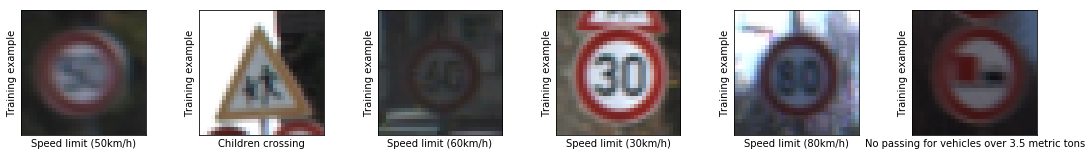

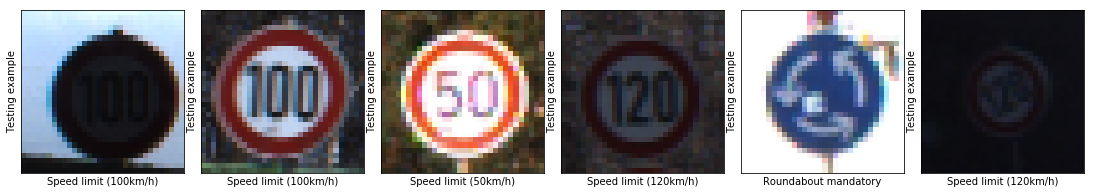

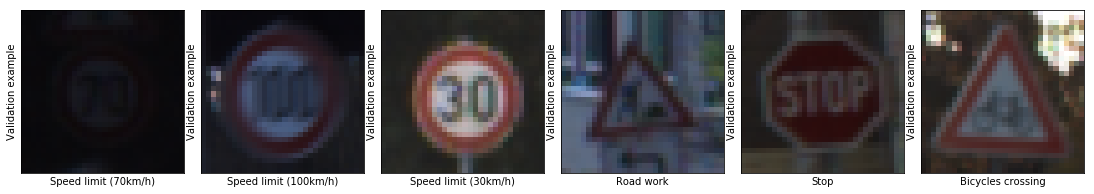

In [6]:
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

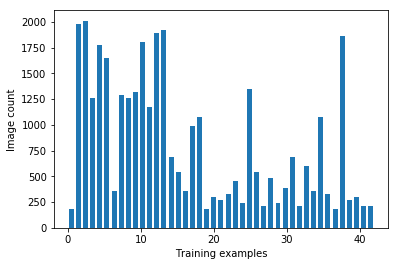

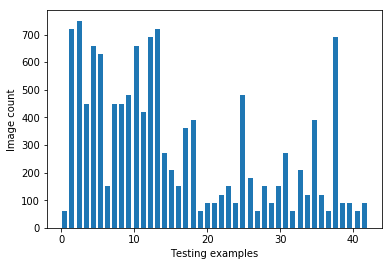

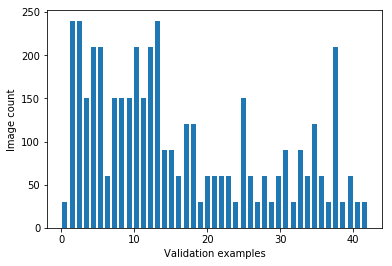

In [7]:
# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

In [8]:
X_train, y_train = shuffle(X_train, y_train)

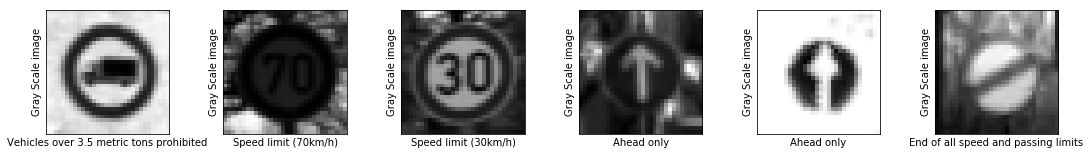

In [9]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

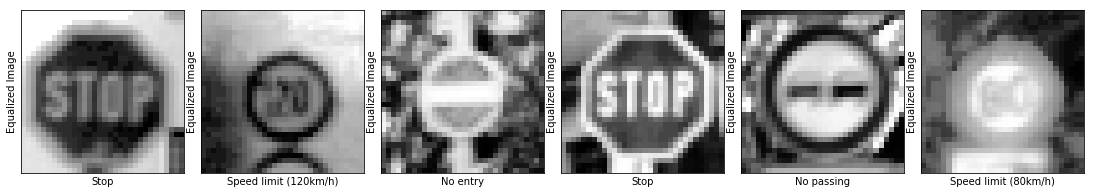

In [10]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

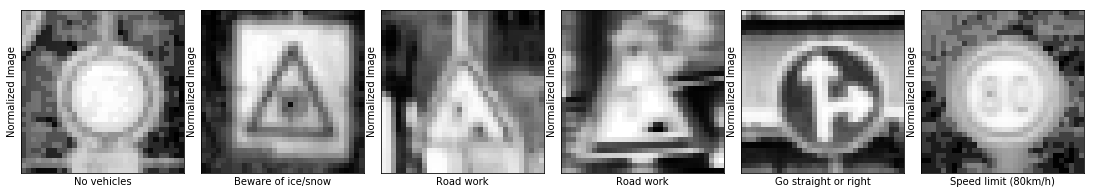

In [11]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [12]:
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name="x")
y = tf.placeholder(tf.int32, (None), name="y")

In [14]:
keep_prob = tf.placeholder(tf.float32, (None), name="keep_prob")       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32, (None), name="keep_prob_conv")  # For convolutional layers

In [15]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [16]:
# increase this to improve the accuracy
# decrease to train faster
EPOCHS = 2
# how many images to train on as a percentage of the total set
# increase this to improve the accuracy
# decrease to train faster
USE_IMAGE_PERCENT = 1
# calculate how many images to use to train
IMAGES_TO_TRAIN_ON = int(len(y_train) * (USE_IMAGE_PERCENT/100))
DIR = 'roadsigns_model'
CHECKPOINT_DIR = '/tmp/roadsigns_model'
ds.parameter('epochs', EPOCHS)
ds.parameter('training_size', IMAGES_TO_TRAIN_ON)

347

In [17]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)
if(os.path.exists(DIR)):
    shutil.rmtree(DIR)
if(os.path.exists(CHECKPOINT_DIR)):
    shutil.rmtree(CHECKPOINT_DIR)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Training...")
    print("Using {} images to train".format(IMAGES_TO_TRAIN_ON))
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, IMAGES_TO_TRAIN_ON, 64):
            print("Running batch: {}, image batch: {}".format(i+1, offset))
            end = offset + 64
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    simple_save(
        sess,
        DIR + "/1",
        inputs={
            "x": x,
            "keep_prob": keep_prob,
            "keep_prob_conv": keep_prob_conv
        },
        outputs={"y": y}
    )
    VGGNet_Model.saver.save(sess, os.path.join(CHECKPOINT_DIR, model_name))
    print("Model saved: {:.3f}%".format(validation_accuracy*100))
    ds.summary('accuracy', validation_accuracy)

Training...
Using 347 images to train

Running batch: 1, image batch: 0
Running batch: 1, image batch: 64
Running batch: 1, image batch: 128
Running batch: 1, image batch: 192
Running batch: 1, image batch: 256
Running batch: 1, image batch: 320
EPOCH 1 : Validation Accuracy = 4.354%
Running batch: 2, image batch: 0
Running batch: 2, image batch: 64
Running batch: 2, image batch: 128
Running batch: 2, image batch: 192
Running batch: 2, image batch: 256
Running batch: 2, image batch: 320
EPOCH 2 : Validation Accuracy = 4.875%
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: roadsigns_model/1/saved_model.pb
Model saved: 4.875%


In [22]:
ds.label("model.directory", ds.output(DIR))
ds.label("model.framework", "tensorflow")
ds.label("model.framework.version", "0.0.1")
ds.publish()

[[DOTSCIENCE-RUN:915b29a4-642a-4d4f-bcb8-692f0a0fc65a]]{
    "end": "20190311T220723.882397",
    "input": [],
    "labels": {
        "model.directory": "roadsigns_model",
        "model.framework": "tensorflow",
        "model.framework.version": "0.0.1"
    },
    "output": [
        "roadsigns_model"
    ],
    "parameters": {
        "epochs": "2",
        "training_size": "347"
    },
    "start": "20190311T211309.734217",
    "summary": {
        "accuracy": "0.043310657596371885"
    },
    "version": "1"
}[[/DOTSCIENCE-RUN:915b29a4-642a-4d4f-bcb8-692f0a0fc65a]]


In [39]:
#example_images = preprocess(X_test[0:1])
#list_images(example_images, y_test, "Normalized Image", "gray")
#f = open("exampleimage.json", "a")
#f.write(json.dumps(example_images[0].tolist()))
print("test")

test


Number of new testing examples:  5


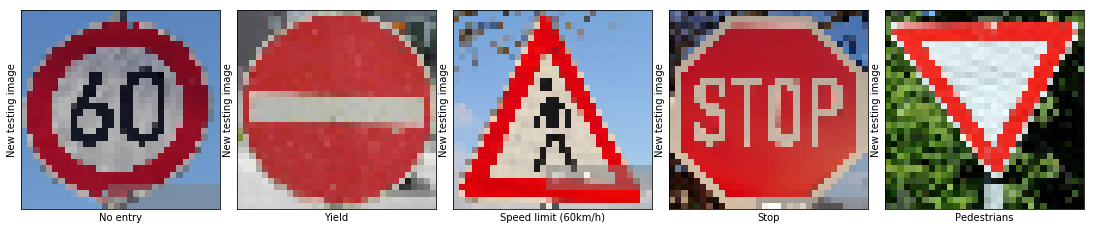

In [18]:
# Loading and resizing new test images
new_test_images = []
path = './new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17]
print("Number of new testing examples: ", len(new_test_images))

plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i-1]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [19]:
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

In [21]:
#example_images = preprocess(X_test[0:1])
#list_images(example_images, y_test, "Normalized Image", "gray")
import json
inputData = {}
inputData["inputs"] = {}
inputData["inputs"]["x"] = new_test_images_preprocessed.tolist()
f = open("test_inputs.json", "a")
f.write(json.dumps(inputData))
f.close()
print("test")

test


INFO:tensorflow:Restoring parameters from /tmp/roadsigns_model/VGGNet
New Images Test Accuracy = 0.0%


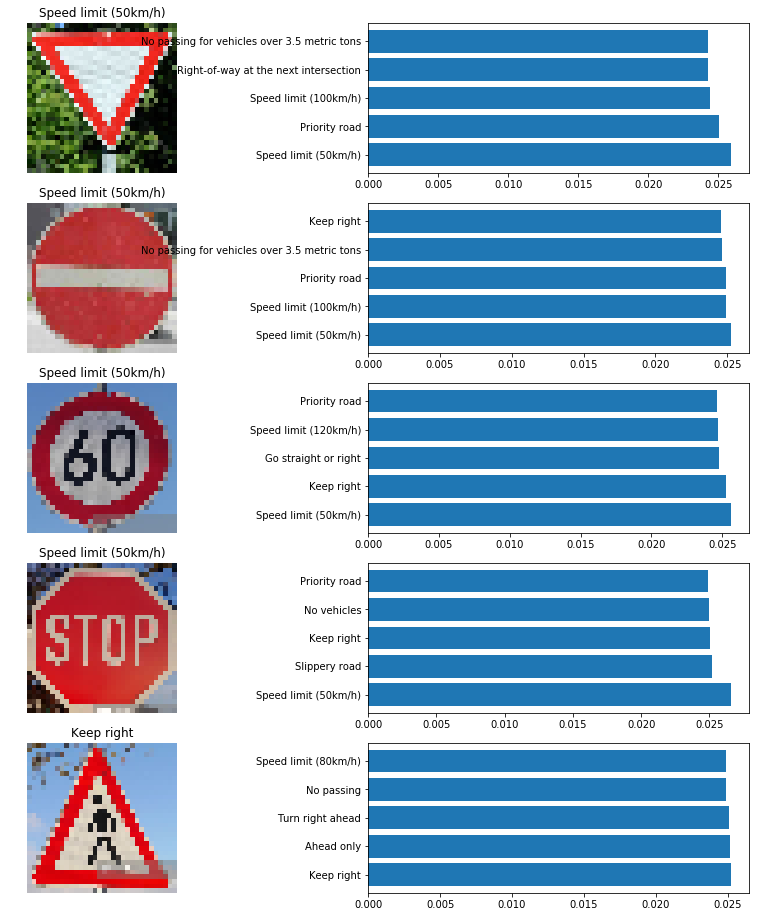

In [73]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(CHECKPOINT_DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
for i in range(len(new_test_images_preprocessed)):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()